In [2]:
import os, glob, math, random
from datetime import datetime
from scipy import stats
from sklearn import metrics
import math
import numpy as np
import pandas as pd
import rasterio
from datetime import datetime
from torch.optim.lr_scheduler import ReduceLROnPlateau
from matplotlib.collections import LineCollection
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from rasterio.plot import show as rio_show
import re
from rasterio.transform import array_bounds
from matplotlib.lines import Line2D
import matplotlib.cm as cm
from tqdm import tqdm
F32_MIN = np.float32(-3.4028235e+38).item()  # ~ -3.40282306e+38 in your files
import pickle
from matplotlib import patheffects as pe
import shapefile
import math, torch, torch.nn as nn, torch.nn.functional as F
from dataclasses import dataclass
import csv
from copy import deepcopy
from tqdm import tqdm
from scipy.spatial.distance import pdist, squareform
from scipy.ndimage import gaussian_filter
import csv
import numpy as np
import torch
import os
import re
import numpy as np
from datetime import datetime
from torch.utils.data import Dataset
import rasterio
import pandas as pd
import torch
import matplotlib.pyplot as plt
import scipy
import sys
import os
sys.path.insert(0, os.path.abspath('..'))
%load_ext autoreload
%autoreload 2
from sklearn.model_selection import train_test_split
import numpy as np
from torch.utils.data import DataLoader,Dataset
import torch
from tqdm import tqdm
import csv
from src.data import  Normalizer, load_classification_pickle, _rowcol_to_xy_vec, _wrap_lon_180, _lonlat_to_rowcol_vec, custom_collate_fn
from src.losses import calculate_metrics, improved_loss_progress
from src.utils import _add_shape,load_shapefile_segments_pyshp, generate_realistic_gaps_simple
complete, partial, blank = load_classification_pickle(input_file='/work/srs108/pconv2d/file_classification_nop.pkl')
train_files, val_files = train_test_split(complete, test_size=0.2, random_state=42)
tif_dir = '/work/srs108/bigs'
z = np.load("/hpc/home/srs108/normalizer_stats.npz", allow_pickle=True)
normalizer = Normalizer(clip_z=5.0)
normalizer.im_mu = float(z["im_mu"]); normalizer.im_sigma = float(z["im_sigma"])
shp_path="/work/srs108/pconv2d/cus/cb_2018_us_state_500k.shp"
pandora_df = pd.read_csv("/work/srs108/pconv2d/pandora_filtered_data_old.csv", header =0)
pandora_df["datetime"] = pd.to_datetime(pandora_df["datetime"], errors="coerce")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def load_shapefile_segments_pyshp(shp_path, target_crs):
    """
    Returns a list of Nx2 arrays of (x,y) segments in the raster's CRS,
    suitable for matplotlib LineCollection.
    """
    import os
    import numpy as np
    import shapefile  # pyshp
    from pyproj import CRS, Transformer
    from shapely.geometry import shape as shp_shape, LineString, MultiLineString, Polygon, MultiPolygon
    from shapely.ops import transform as shp_transform

    if target_crs is None:
        raise ValueError("target_crs is None (couldn't read raster CRS).")

    # Try to read the .prj next to the .shp; fallback to WGS84
    prj_path = os.path.splitext(shp_path)[0] + ".prj"
    if os.path.exists(prj_path):
        with open(prj_path, "r") as f:
            src_crs = CRS.from_wkt(f.read())
    else:
        src_crs = CRS.from_epsg(4326)  # common default

    transformer = Transformer.from_crs(src_crs, target_crs, always_xy=True)

    rdr = shapefile.Reader(shp_path)
    segments = []

    for sr in rdr.shapeRecords():
        geom = shp_shape(sr.shape.__geo_interface__)

        # Normalize to a list of LineStrings (polygon outlines become lines)
        line_geoms = []
        if isinstance(geom, LineString):
            line_geoms = [geom]
        elif isinstance(geom, MultiLineString):
            line_geoms = list(geom.geoms)
        elif isinstance(geom, Polygon):
            line_geoms = [LineString(geom.exterior.coords)] + [LineString(r.coords) for r in geom.interiors]
        elif isinstance(geom, MultiPolygon):
            for poly in geom.geoms:
                line_geoms.append(LineString(poly.exterior.coords))
                line_geoms += [LineString(r.coords) for r in poly.interiors]
        else:
            continue  # skip points, etc.

        # Reproject & extract segments
        for g in line_geoms:
            g2 = shp_transform(lambda x, y: transformer.transform(x, y), g)
            coords = np.asarray(g2.coords, dtype=np.float32)
            if coords.shape[0] >= 2:
                segments.append(coords)

    return segments


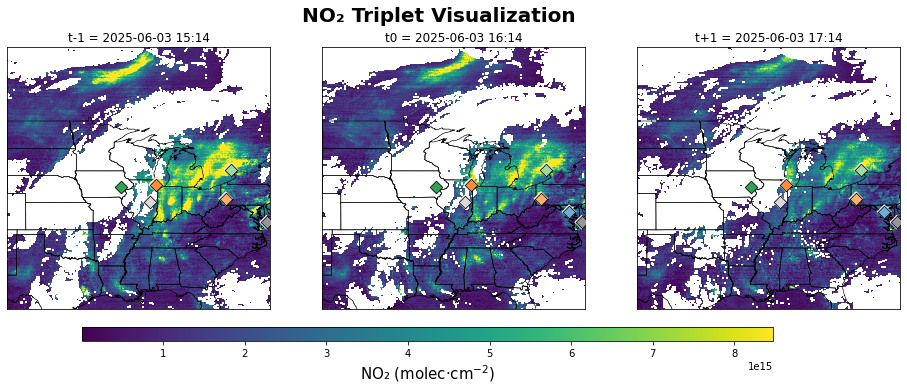

In [4]:
class TempoPandoraInterpDataset(Dataset):
    """
    Dataset for temporal interpolation/next-frame prediction.
    - Input: frames [t-1, t, t+1]
    - Target: single frame (t+1 or midpoint, depending on use)
    Includes Pandora overlays and shapefile-aware visualization.
    """
    F32_MIN = np.float32(-3.4028235e+38).item()
    def __init__(self,
                 tif_dir,
                 normalizer,
                 file_list,
                 train=True,
                 pandora_csv=None,
                 time_tolerance="30min"):
        self.tif_dir = tif_dir
        self.normalizer = normalizer
        self.train = bool(train)
        self.time_tolerance = pd.Timedelta(time_tolerance)

        # Order files by timestamp
        self.files = list(file_list)
        self.timestamps = [self._parse_time_from_fname(os.path.basename(p)) for p in self.files]
        order = np.argsort(np.array(self.timestamps, dtype="datetime64[ns]"))
        self.files = [self.files[i] for i in order]
        self.timestamps = [self.timestamps[i] for i in order]
        self.use_dataset_mask =True
        self.treat_zeros_as_missing = False
        self.valid_range = None
        
        
        # Pandora CSV
        self.pandora_df = None
        if pandora_csv is not None:
            df = pd.read_csv(pandora_csv) if isinstance(pandora_csv, str) else pandora_csv.copy()
            df["datetime"] = pd.to_datetime(df["datetime"])
            df = df.sort_values("datetime").reset_index(drop=True)
            self.pandora_df = df

    def __len__(self):
        # Need triplets, so N-2 samples
        return len(self.files) - 2

    def __getitem__(self, idx):
        # paths for t-1, t, t+1
        paths = self.files[idx:idx+3]
        ts_list = self.timestamps[idx:idx+3]

        imgs, masks = [], []
        for p in paths:
            arr, m = self._read_band_masked(p)
            arr = np.nan_to_num(arr, nan=0.0).astype(np.float32)
            arr = self.normalizer.normalize_image(arr)
            imgs.append(arr)
            masks.append(m.astype(np.float32))

        imgs = np.stack(imgs, axis=0)   # [3,H,W]
        masks = np.stack(masks, axis=0) # [3,H,W]

        x = torch.from_numpy(imgs).unsqueeze(0)    # [1,3,H,W]
        m = torch.from_numpy(masks).unsqueeze(0)   # [1,3,H,W]

        # Target frame = t+1 (last in triplet)
        y = torch.from_numpy(imgs[-1]).unsqueeze(0).unsqueeze(0)  # [1,1,H,W]

        return {
            "img_in": x, "mask_in": m, "target": y,
            "paths": paths, "timestamps": ts_list
        }

    # ----------------- helpers -----------------
    @staticmethod
    def _parse_time_from_fname(fname):
        digits = re.sub(r"\D", "", fname)
        fmts = ("%Y%m%d%H%M%S", "%Y%m%d%H%M", "%Y%m%d%H", "%Y%m%d")
        for fmt in fmts:
            try:
                return pd.to_datetime(digits[:len(pd.Timestamp.now().strftime(fmt))], format=fmt)
            except Exception:
                continue
        return pd.NaT

    def _read_band_masked(self, path):
        with rasterio.open(path) as src:
            gdal_known = None
            if self.use_dataset_mask:
                try:
                    m = src.read_masks(1)  # 0=missing, 255=valid
                    if m is not None and m.size:
                        gdal_known = (m > 0)
                except Exception:
                    gdal_known = None

            arr = src.read(1, out_dtype='float64')
            nodatas = []
            if getattr(src, "nodata", None) is not None:
                nodatas.append(src.nodata)
            if getattr(src, "nodatavals", None):
                nodatas += [v for v in src.nodatavals if v is not None]

        known = gdal_known if gdal_known is not None else np.isfinite(arr)
        for nv in nodatas:
            known &= arr != nv
        known &= arr > (self.F32_MIN * 0.9)
        if self.treat_zeros_as_missing:
            known &= arr != 0.0
        if self.valid_range is not None:
            vmin, vmax = self.valid_range
            known &= (arr >= vmin) & (arr <= vmax)

        arr_valid = np.where(known, arr, np.nan)
        return arr_valid, known.astype(np.uint8)


    def sample_vis(self, idx=None, max_cols=3, shp_path=shp_path,plot_pandora=True, seed=42, denormalize=True):

        rng = np.random.default_rng(seed)
        if idx is None:
            idx = rng.integers(len(self))

        sample = self[idx]

        def _add_shape_and_pandora(ax, tr, crs, ts, segments, plot_pandora=True):
            """Draw shapefile lines + Pandora stations with categorical colors."""
            if segments:
                ax.add_collection(LineCollection(segments, colors='k',
                                                 linewidths=0.6, zorder=3))

            has_pandora = False
            legend_handles, shown_labels = [], []

            if (plot_pandora and getattr(self, "pandora_df", None) is not None
                and ts is not pd.NaT and not self.pandora_df.empty
                and "station" in self.pandora_df.columns):

                dfw = self.pandora_df[
                    (self.pandora_df["datetime"] >= ts - self.time_tolerance) &
                    (self.pandora_df["datetime"] <= ts + self.time_tolerance)
                ].copy()
                if dfw.empty:
                    return has_pandora, legend_handles, shown_labels

                dfw["abs_dt"] = (dfw["datetime"] - ts).abs()
                dfw = dfw.sort_values(["station","abs_dt"]).groupby("station").first().reset_index()

                stations_all = self.pandora_df["station"].dropna().astype(str).unique()
                palette = cm.tab20c(np.linspace(0, 1, max(1,len(stations_all))))
                station2color = dict(zip(stations_all, palette))

                if {"row","col"}.issubset(dfw.columns):
                    rows = dfw["row"].astype(int).to_numpy()
                    cols = dfw["col"].astype(int).to_numpy()
                elif {"lat","lon"}.issubset(dfw.columns):
                    xs = pd.to_numeric(dfw["lon"], errors="coerce").to_numpy()
                    ys = pd.to_numeric(dfw["lat"], errors="coerce").to_numpy()
                    ok = np.isfinite(xs) & np.isfinite(ys)
                    dfw = dfw.loc[ok]
                    coords = [~tr * (x,y) for x,y in zip(xs[ok], ys[ok])]
                    cols = np.array([int(round(c)) for c,r in coords])
                    rows = np.array([int(round(r)) for c,r in coords])
                else:
                    return has_pandora, legend_handles, shown_labels

                H, W = ax.images[0].get_array().shape
                ok_in = (rows >= 0) & (rows < H) & (cols >= 0) & (cols < W)
                if ok_in.sum() == 0:
                    return has_pandora, legend_handles, shown_labels

                rows, cols = rows[ok_in], cols[ok_in]
                labels = dfw.loc[ok_in, "station"].astype(str).to_numpy()

                # row/col → x/y
                xs, ys = [], []
                for r, c in zip(rows, cols):
                    x, y = tr * (c, r)   # col,row → map coords
                    xs.append(x); ys.append(y)

                has_pandora = True

                # halo + diamonds
                ax.scatter(xs, ys, s=110, marker='D', facecolor='white',
                           edgecolor='none', zorder=7)
                for x,y,lab in zip(xs, ys, labels):
                    c = station2color.get(lab,(0.2,0.2,0.2,1.0))
                    ax.scatter(x,y,s=80,marker='D',facecolor=c,
                               edgecolor='k',linewidth=0.8,zorder=8)

                for lab in np.unique(labels):
                    c = station2color.get(lab,(0.2,0.2,0.2,1.0))
                    proxy = Line2D([0],[0],marker='D',color='none',
                                   markerfacecolor=c,markeredgecolor='k',
                                   markeredgewidth=0.8,markersize=9,label=lab)
                    legend_handles.append(proxy)
                shown_labels = list(np.unique(labels))

            return has_pandora, legend_handles, shown_labels

        # ---------------- Data ----------------
        imgs = sample["img_in"].squeeze().numpy()  # [3,H,W]
        masks = sample["mask_in"].squeeze().numpy().astype(bool)
        ts_list = sample["timestamps"]
        paths = sample["paths"]

        # Denormalize if possible
        if denormalize and hasattr(self,"normalizer") and self.normalizer:
            imgs = np.stack([self.normalizer.denormalize_image(im) for im in imgs])

        finite = np.isfinite(imgs)
        vmin,vmax = (np.percentile(imgs[finite],[1,99]) if finite.any() else (0,1))

        cmap_v = plt.cm.viridis.copy()
        cmap_v.set_bad("white")  # NaNs show as white

        # Shapefile
        segments, ref_tr, ref_crs = [], None, None
        if shp_path and len(paths)>0:
            with rasterio.open(paths[0]) as src0:
                ref_tr, ref_crs = src0.transform, src0.crs
                segments = load_shapefile_segments_pyshp(shp_path, ref_crs)

        # Layout
        fig, axes = plt.subplots(1,3,figsize=(16,5),squeeze=False)
        axes = axes[0]
        legend_handles_all, used_any_stations = None, False

        for k in range(3):
            arr, ts, path, mask = imgs[k], ts_list[k], paths[k], masks[k]
            with rasterio.open(path) as src:
                tr, crs = src.transform, src.crs
                xmin,ymin,xmax,ymax = array_bounds(src.height, src.width, tr)

            ax = axes[k]
            mask_combined = ~mask

            arr_masked = np.ma.array(arr, mask=mask_combined)

            ax_img=ax.imshow(arr_masked, cmap=cmap_v, vmin=vmin, vmax=vmax,
              extent=[xmin, xmax, ymin, ymax], origin="upper")

            has_pandora, legend_handles, shown_labels = _add_shape_and_pandora(
                ax,tr,crs,ts,segments,plot_pandora)
            if has_pandora and not used_any_stations and legend_handles:
                legend_handles_all = legend_handles
                used_any_stations = True

            ts_str = ts.strftime("%Y-%m-%d %H:%M") if ts is not pd.NaT else str(path)
            ax.set_title(f"t{['-1','0','+1'][k]} = {ts_str}", fontsize=12)
            ax.set_aspect('equal')
            ax.set_xlim(xmin,xmax); ax.set_ylim(ymin,ymax)
            ax.tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)

            if k==0: first_im=ax_img

        # Colorbar
        if 'first_im' in locals():
            cbar_ax = fig.add_axes([0.19, 0.05, 0.6, 0.04])  # [left, bottom, width, height] in figure coords
            cbar = fig.colorbar(first_im, cax=cbar_ax, orientation="horizontal")
            
            cbar.set_label("NO₂ (molec·cm$^{-2}$)", fontsize=15)
#             cbar = fig.colorbar(first_im, ax=axes, fraction=0.025, pad=0.02)


        # Pandora legend
#         if used_any_stations and legend_handles_all:
#             axes[0].legend(handles=legend_handles_all,
#                            bbox_to_anchor=(-0.85,1.0), loc="upper left",
#                            frameon=True, fontsize=12, markerscale=1.2,
#                            title="Pandora Stations")

        fig.suptitle("NO₂ Triplet Visualization", fontsize=20, fontweight='bold', y=0.98)
        plt.savefig('no2_triplet.png', dpi=150, bbox_inches="tight", facecolor='white')
        plt.show()

ds=  TempoPandoraInterpDataset(tif_dir, normalizer,train_files,train=True,pandora_csv=pandora_df,time_tolerance="30min")
ds.sample_vis(3535)

In [5]:
ds[0]

{'img_in': tensor([[[[-5.0000, -5.0000, -5.0000,  ..., -5.0000, -5.0000, -5.0000],
           [-5.0000, -5.0000, -5.0000,  ..., -5.0000, -5.0000, -5.0000],
           [-5.0000, -5.0000, -5.0000,  ..., -5.0000, -5.0000, -5.0000],
           ...,
           [-5.0000, -5.0000, -5.0000,  ..., -1.5146, -0.1476, -0.3354],
           [-5.0000, -5.0000, -5.0000,  ..., -0.3908, -1.0478, -5.0000],
           [-5.0000, -5.0000, -5.0000,  ..., -3.2540, -0.3599, -0.9802]],
 
          [[-5.0000, -5.0000, -5.0000,  ..., -5.0000, -5.0000, -5.0000],
           [-5.0000, -5.0000, -5.0000,  ..., -5.0000, -5.0000, -5.0000],
           [-5.0000, -5.0000, -5.0000,  ..., -5.0000, -5.0000, -5.0000],
           ...,
           [-0.3691, -0.6396, -0.5120,  ..., -0.0325,  0.2406, -0.0839],
           [-1.1712, -0.6434, -1.3456,  ...,  0.3839, -5.0000, -5.0000],
           [-1.0821, -3.6873, -0.8471,  ..., -5.0000,  0.2064,  0.1791]],
 
          [[-5.0000, -5.0000, -5.0000,  ..., -5.0000, -5.0000, -5.0000],
   

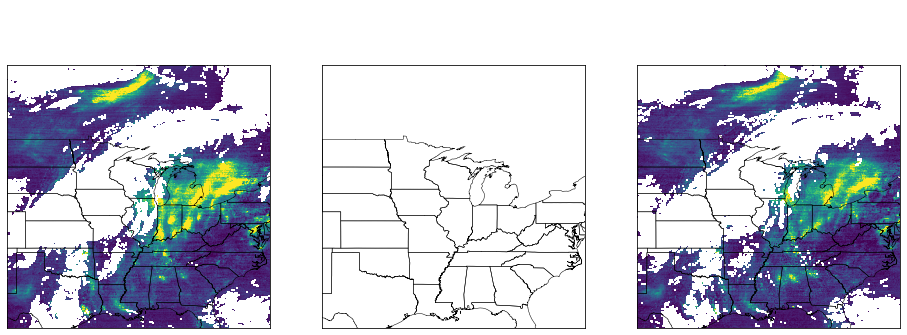

In [5]:
def sample_vis(idx, shp_path=shp_path,
               seed=42, normalizer=normalizer, save=True):
    sample = ds[idx]

    # --- Data ---
    imgs = sample["img_in"].squeeze().numpy()   # [3,H,W]
    masks = sample["mask_in"].squeeze().numpy().astype(bool)
    ts_list, paths = sample["timestamps"], sample["paths"]

    if hasattr(normalizer, "denormalize_image"):
        imgs = np.stack([normalizer.denormalize_image(im) for im in imgs])

    finite = np.isfinite(imgs)
    vmin, vmax = (np.percentile(imgs[finite], [1,99]) if finite.any() else (0,1))

    cmap_v = plt.cm.viridis.copy()
    cmap_v.set_bad("white")

    # Shapefile segments
    segments, ref_tr, ref_crs = [], None, None
    if shp_path and len(paths) > 0:
        with rasterio.open(paths[0]) as src0:
            ref_tr, ref_crs = src0.transform, src0.crs
            segments = load_shapefile_segments_pyshp(shp_path, ref_crs)

    # Layout
# Layout: 3 panels
    fig, axes = plt.subplots(1, 3, figsize=(16, 5), squeeze=False)
    axes = axes[0]

    # Left panel = t0
    arr0, ts0, path0, mask0 = imgs[0], ts_list[0], paths[0], masks[0]
    with rasterio.open(path0) as src:
        tr, crs = src.transform, src.crs
        xmin, ymin, xmax, ymax = array_bounds(src.height, src.width, tr)

    arr0_masked = np.ma.array(arr0, mask=(~mask0 | ~np.isfinite(arr0)))
    ax0 = axes[0]
    ax_img = ax0.imshow(arr0_masked, cmap=cmap_v, vmin=vmin, vmax=vmax,
                        extent=[xmin, xmax, ymin, ymax], origin="upper")
    ax0.set_title(f"t0\n{ts0.strftime('%Y-%m-%d %H:%M')}", fontsize=15, color = 'white' if save else 'black')
    ax0.set_aspect("equal"); ax0.set_xlim(xmin, xmax); ax0.set_ylim(ymin, ymax)
    ax0.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    ax0.add_collection(LineCollection(segments, colors="k", linewidths=0.5))
    first_im = ax_img

    # Middle panel = empty with shapefile
    ax1 = axes[1]
    ax1.set_title("t + 0.5\n2025-06-03 15:44", fontsize=15, color = 'white' if save else 'black')
    ax1.set_aspect("equal")
    ax1.set_xlim(xmin, xmax); ax1.set_ylim(ymin, ymax)
    ax1.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    if segments:
        ax1.add_collection(LineCollection(segments, colors="k", linewidths=0.5, zorder=3))

    # Right panel = t+1
    arr1, ts1, path1, mask1 = imgs[1], ts_list[1], paths[1], masks[1]
    with rasterio.open(path1) as src:
        tr, crs = src.transform, src.crs
        xmin, ymin, xmax, ymax = array_bounds(src.height, src.width, tr)

    arr1_masked = np.ma.array(arr1, mask=(~mask1 | ~np.isfinite(arr1)))
    ax2 = axes[2]
    ax2.imshow(arr1_masked, cmap=cmap_v, vmin=vmin, vmax=vmax,
               extent=[xmin, xmax, ymin, ymax], origin="upper")
    ax2.set_title(f"t+1\n{ts1.strftime('%Y-%m-%d %H:%M')}", fontsize=15, color = 'white' if save else 'black')
    ax2.set_aspect("equal"); ax2.set_xlim(xmin, xmax); ax2.set_ylim(ymin, ymax)
    ax2.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    ax2.add_collection(LineCollection(segments, colors="k", linewidths=0.5))

    fig.suptitle("NO₂ Intrahourly Setup", fontsize=20, fontweight="bold", y=1.03, color = 'white' if save else 'black')

    plt.savefig('poster_future.png', dpi=150, bbox_inches="tight")

    plt.show()
sample_vis(3535, shp_path=shp_path,seed=42, normalizer=normalizer)

In [3]:
class PConvUNet3D(nn.Module):
    """
    3D PConv U-Net for contextual prediction.
    - Input:  [B, 1, 3, H, W]  (frames at t-1, t, t+1)
    - Output: [B, 1, H, W]     (predicted single frame, e.g. t+1 or t+0.5)
    """
    def __init__(self, features=(32,64,128,256), norm="in"):
        super().__init__()
        chs = [1] + list(features)

        # ---------------- Encoder ----------------
        downs = []
        for i in range(len(features)):
            downs.append(nn.ModuleList([
                PConvBNAct3D(chs[i], chs[i+1], k=3, s=1, p=1, norm=norm),
                PConvBNAct3D(chs[i+1], chs[i+1], k=3, s=2, p=1, norm=norm),
            ]))
        self.downs = nn.ModuleList(downs)

        # ---------------- Bottleneck ----------------
        self.bottleneck1 = PConvBNAct3D(features[-1], features[-1]*2, k=3, s=1, p=1, norm=norm)
        self.bottleneck2 = PConvBNAct3D(features[-1]*2, features[-1], k=3, s=1, p=1, norm=norm)

        # ---------------- Decoder ----------------
        ups = []
        for i in reversed(range(len(features))):
            in_dec = features[i] + (features[i+1] if i < len(features)-1 else features[i])
            ups.append(nn.ModuleList([
                PConvBNAct3D(in_dec, features[i], k=3, s=1, p=1, norm=norm),
                PConvBNAct3D(features[i], features[i], k=3, s=1, p=1, norm=norm),
            ]))
        self.ups = nn.ModuleList(ups)

        # ---------------- Head ----------------
        # Predict a single frame (no temporal depth in output).
        self.head = PartialConv3d(features[0], 1, kernel_size=(1,1,1))

    @staticmethod
    def _upsample_feat_mask(x, m, size):
        # Trilinear upsample for features, nearest for masks
        x_up = F.interpolate(x, size=size, mode="trilinear", align_corners=False)
        m_up = F.interpolate(m, size=size, mode="nearest")
        return x_up, (m_up > 0.5).float()

    def forward(self, x, m):
        """
        x: [B, 1, 3, H, W]
        m: [B, 1, 3, H, W]
        returns: y_pred [B, 1, H, W]
        """
        # --------- Encoder ---------
        skips = []
        h, mh = x, m
        for block1, block2 in self.downs:
            h, mh = block1(h, mh)
            h, mh = block2(h, mh)
            skips.append((h, mh))

        # --------- Bottleneck ---------
        h, mh = self.bottleneck1(h, mh)
        h, mh = self.bottleneck2(h, mh)

        # --------- Decoder ---------
        for (block1, block2), (skip_h, skip_m) in zip(self.ups, reversed(skips)):
            h, mh = self._upsample_feat_mask(h, mh, size=skip_h.shape[2:])
            h = torch.cat([h, skip_h], dim=1)
            mh = torch.maximum(mh, skip_m)
            h, mh = block1(h, mh)
            h, mh = block2(h, mh)

        # --------- Head ---------
        y, _ = self.head(h, mh)   # [B,1,1,H,W]
        y = y.squeeze(2)          # remove temporal depth → [B,1,H,W]
        return y


In [4]:
class InterpLoss(nn.Module):
    """
    Simple MAE/MSE loss for interpolation targets.
    """
    def __init__(self, mode="mae"):
        super().__init__()
        self.mode = mode

    def forward(self, pred, target):
        if self.mode == "mae":
            return F.l1_loss(pred, target)
        else:
            return F.mse_loss(pred, target)


In [ ]:
model = PConvInterpUNet3D().to(device)
criterion = InterpLoss(mode="mae")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        x = batch["masked_img"].to(device)   # [B,1,3,H,W]
        y = batch["target"].to(device)       # [B,1,2,H,W]
        m = torch.ones_like(x)               # assume fully valid inputs

        pred = model(x, m)                   # [B,2,H,W]
        loss = criterion(pred, y.squeeze(1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch}: train loss {loss.item():.4f}")


In [ ]:
def run_interpolation_inference_and_plot(model, dataset, idx=0, shp_path=None, plot_pandora=True,
                                         denormalize=True, save_path=None, device="cuda"):
    """
    Runs inference for temporal interpolation:
    [t-1] → [pred t-0.5] → [t] → [pred t+0.5] → [t+1]
    and plots with shapefile + Pandora overlays.
    """

    import matplotlib.pyplot as plt
    from matplotlib.collections import LineCollection
    from matplotlib.lines import Line2D
    import numpy as np
    import rasterio
    from rasterio.transform import array_bounds

    model.eval()

    # ---- Load dataset sample ----
    sample = dataset[idx]
    x = sample["masked_img"].unsqueeze(0).to(device)  # [1,1,3,H,W]
    m = torch.ones_like(x).to(device)                 # fully valid mask
    paths = sample["paths"]                           # list of 3 paths

    with torch.no_grad():
        pred = model(x, m)                            # [1,2,H,W]
    pred = pred.squeeze(0).cpu().numpy()              # [2,H,W]

    # Denormalize if requested
    if denormalize and hasattr(dataset, "normalizer"):
        pred = np.stack([dataset.normalizer.denormalize_image(p) for p in pred], axis=0)

    # ---- Arrange sequence ----
    with rasterio.open(paths[0]) as src:
        tr, crs = src.transform, src.crs
        xmin, ymin, xmax, ymax = array_bounds(src.height, src.width, tr)

    # Read original input images for t-1, t, t+1
    imgs = []
    for p in paths:
        with rasterio.open(p) as src:
            arr = src.read(1).astype(np.float32)
        arr = dataset.normalizer.denormalize_image(arr) if denormalize else arr
        imgs.append(arr)
    imgs = np.stack(imgs, axis=0)   # [3,H,W]

    # Final sequence: [t-1, pred t-0.5, t, pred t+0.5, t+1]
    seq = [imgs[0], pred[0], imgs[1], pred[1], imgs[2]]
    titles = ["t-1", "pred t-0.5", "t", "pred t+0.5", "t+1"]

    # ---- Color scaling ----
    vmin, vmax = np.percentile(np.concatenate(seq).ravel(), [2, 98])
    cmap = plt.cm.viridis.copy(); cmap.set_bad("white")

    # ---- Plotting ----
    fig, axes = plt.subplots(1, 5, figsize=(20, 5), constrained_layout=True)

    for i, ax in enumerate(axes):
        ax.imshow(seq[i], cmap=cmap, vmin=vmin, vmax=vmax,
                  extent=[xmin, xmax, ymin, ymax], origin="upper")

        # Optional shapefile overlay
        segments = []
        if shp_path is not None:
            try:
                segments = load_shapefile_segments_pyshp(shp_path, crs)
                ax.add_collection(LineCollection(segments, colors="k", linewidths=0.6, zorder=3))
            except Exception:
                pass

        # Optional Pandora overlay (center frame only)
        if plot_pandora and i == 2 and hasattr(dataset, "pandora_df"):
            ts_center = sample.get("timestamps", [])[1]
            if ts_center is not None:
                # Plot Pandora points
                p_mask, p_val_map, station_names = dataset._pandora_for_path(paths[1])
                rows, cols = np.where(p_mask > 0)
                if len(rows) > 0:
                    xs, ys = [~tr * (c, r) for r, c in zip(rows, cols)]
                    ax.scatter(xs, ys, s=80, c="red", marker="D", edgecolor="k", linewidth=0.5,
                               label="Pandora station")
                    ax.legend(loc="upper right")

        ax.set_title(titles[i], fontsize=12)
        ax.set_aspect("equal")
        ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

    # Single colorbar
    cbar = fig.colorbar(axes[0].images[0], ax=axes, fraction=0.025, pad=0.02)
    if denormalize:
        cbar.set_label("NO₂ (molec·cm$^{-2}$)", rotation=90)
    else:
        cbar.set_label("NO₂ (normalized)", rotation=90)

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches="tight", facecolor="white")
        print(f"Saved figure to {save_path}")

    plt.show()
